In [ ]:
!pip install tensorflow
!pip install tqdm
!pip install pillow
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 593.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
project_path = '/content/drive/MyDrive/LSTM/DeepLearingProject '

zip_img_path = f"{project_path}/Images.zip"
txt_cap_path = f"{project_path}/captions.txt"

# img extracted will be at
extract_folders = '/content/imgs'


In [ ]:
import zipfile

with zipfile.ZipFile(zip_img_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folders)

print("Imges are extracted to: ", extract_folders)

Imges are extracted to:  /content/imgs


In [ ]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from the image

features = {}
directional = os.path.join(extract_folders, 'Images')

for img_name in tqdm(os.listdir(directional)):
    # load the image from file
    img_path = directional + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8090 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
import pickle

with open('/content/fea_reuse.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Features saved to /content/fea_reuse.pkl")


Features saved to /content/fea_reuse.pkl


In [ ]:
  #  load the captions data

with open(txt_cap_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
with open('/content/fea_reuse.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
  # split the line by comma
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1]
  # remove extension from img id
  image_id = image_id.split('.')[0]
  # convert caption to lowercase
  caption = "".join(caption)
  # create list needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocess
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      # add start and end tags
      caption = 'startseq '+" ".join([word for word in caption.split() if len(word)>1])+ ' endseq'
      captions[i] = caption


In [ ]:
# before preprocess of text
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Save the tokenizer to a .pkl file
import pickle
with open('/content/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved to /content/tokenizer.pkl")

✅ Tokenizer saved to /content/tokenizer.pkl


In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
# Save max_length
with open('/content/max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)
print("✅ max_length saved to /content/max_length.pkl")

✅ max_length saved to /content/max_length.pkl


In [ ]:
import pickle

# Create config dictionary with essential parameters
config = {
    'max_length': max_length,  # This is already calculated in your code
    'vocab_size': vocab_size   # Optional: Add if needed later
}

# Save to config.pkl
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("Config file saved as config.pkl")

Config file saved as config.pkl


In [ ]:
vocab_size

8313

In [ ]:
# get maximum lengt of the captions availale
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

In [ ]:
# train test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data genertor to get data in batch (to avoid session crash)
def datagenerator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loopover imgs
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield (X1, X2), y
        X1, X2, y = list(), list(), list()
        n = 0

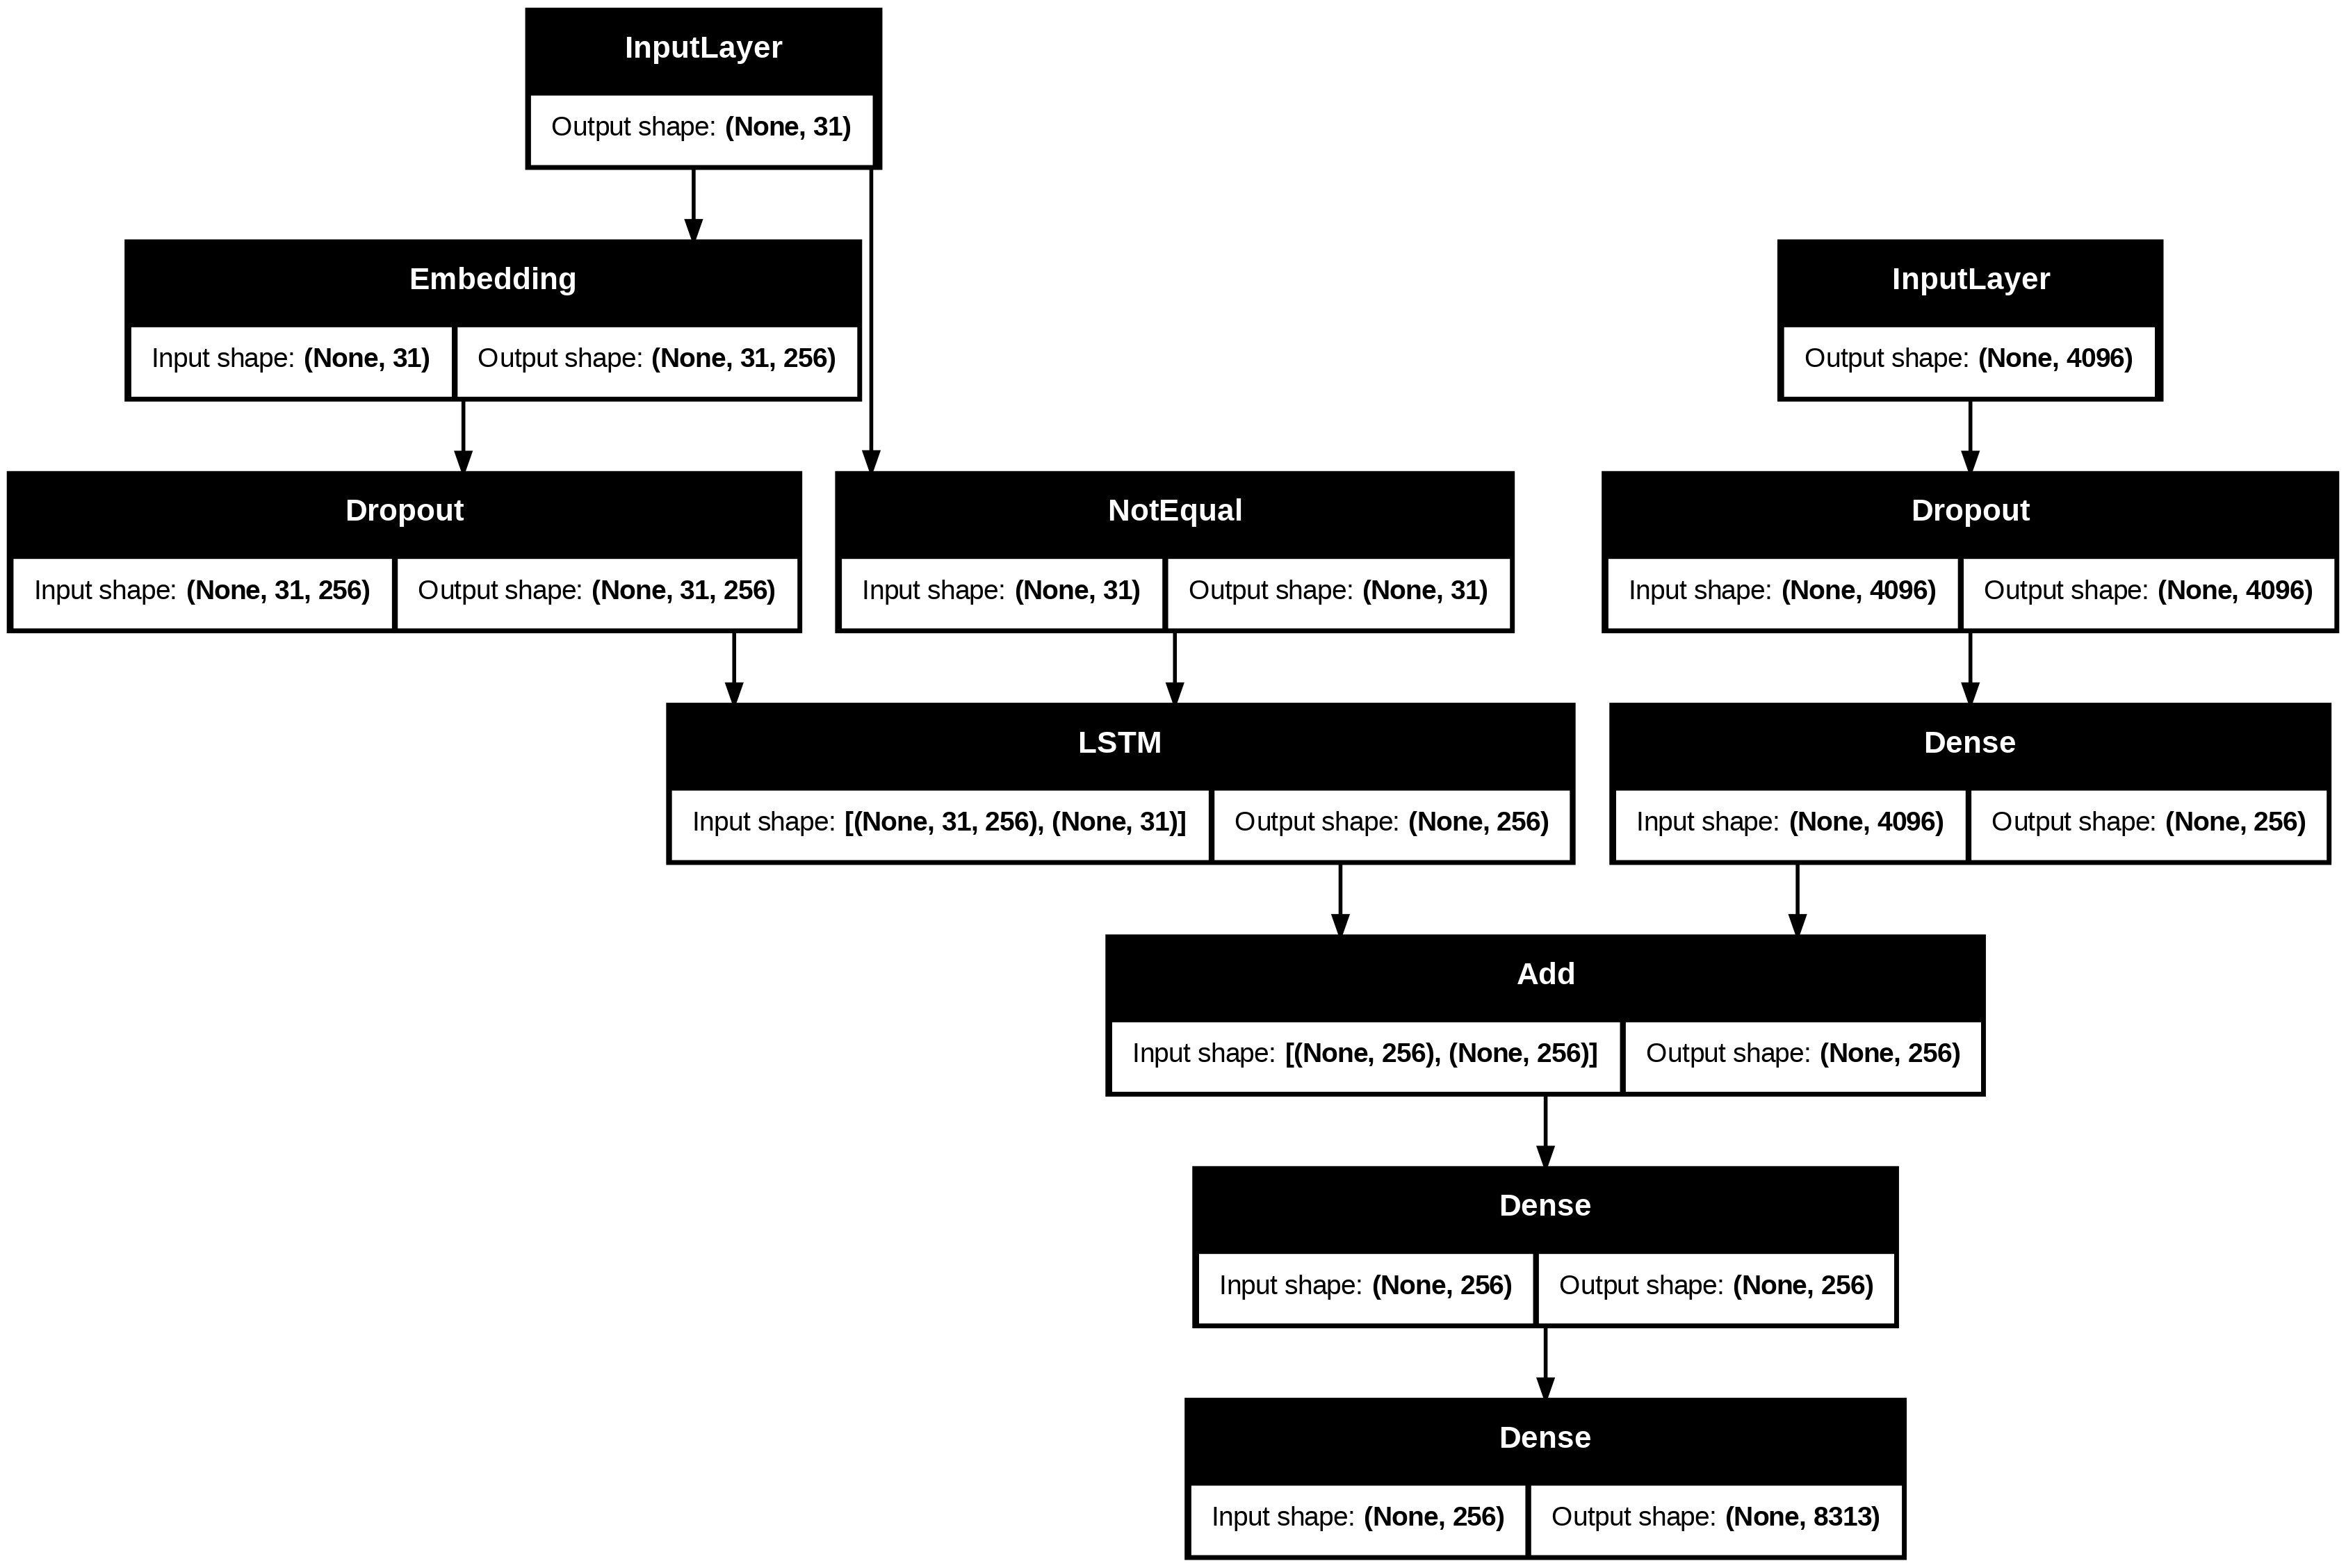

In [ ]:
# modelcreation

# encoder model
# img feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq fature layers
inputs2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)




# decoder model
decoder1 = add([fe2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# FILTER: Keep only image-caption mappings where features exist
mapping = {k: v for k, v in mapping.items() if k in features}

# FILTER: Update train list accordingly
train = [img_id for img_id in train if img_id in features]

# new
val = [img_id for img_id in test if img_id in features]

In [ ]:
# train the model with early stopping and validation

epochs = 15
batch_size = 64
steps = len(train) // batch_size
val_steps = len(val) // batch_size

# Generators
train_generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = datagenerator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1021s 9s/step - loss: 6.1467 - val_loss: 4.7359
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1044s 9s/step - loss: 4.4151 - val_loss: 3.9770
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1042s 9s/step - loss: 3.7374 - val_loss: 3.8288
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 997s 9s/step - loss: 3.4343 - val_loss: 3.7827
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1004s 9s/step - loss: 3.2215 - val_loss: 3.7788
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 996s 9s/step - loss: 3.0693 - val_loss: 3.7810
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1042s 9s/step - loss: 2.9462 - val_loss: 3.8281
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 992s 9s/step - loss: 2.8403 - val_loss: 3.8651


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [ ]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'accuracy'

<Figure size 800x500 with 0 Axes>

In [ ]:
# # train the model
# epochs = 15
# batch_size = 64
# steps = len(train) // batch_size

# for i in range(epochs):
#   # create data generator
#   generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#   # fit for i epoch
#   model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# save the model
model.save('model.h5')

In [ ]:
# Generate Captions for the image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# validate with text data
actual, predict = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predict.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.591675
BLEU-2: 0.363050


In [ ]:
# visualize the results
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def generate_captions(image_name):
    # load the img
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog chases the water from sprinkler on lawn endseq
startseq brown dog plays with the hose endseq
startseq brown dog running on lawn near garden hose endseq
startseq dog is playing with hose endseq
startseq large brown dog running away from the sprinkler in the grass endseq
--------------------Predicted--------------------
startseq brown dog is running through the grass endseq


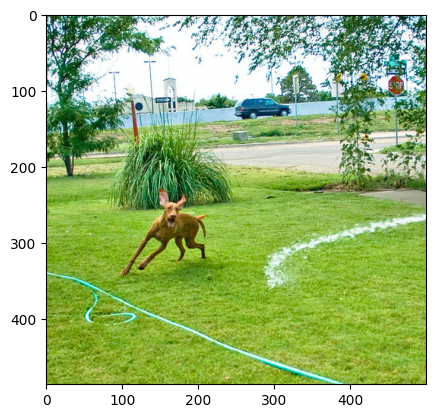

In [ ]:
generate_captions('1019077836_6fc9b15408.jpg')

---------------------Actual---------------------
startseq people are riding around on snowmobiles endseq
startseq people pose with helmets and goggles on while riding snowmobiles endseq
startseq several people are taking break while on snowmobiling ride endseq
startseq three people and two snowmobiles endseq
startseq two helmeted men sit on yellow snowmobiles while another man stands behind watching endseq
--------------------Predicted--------------------
startseq man in red helmet riding up up endseq


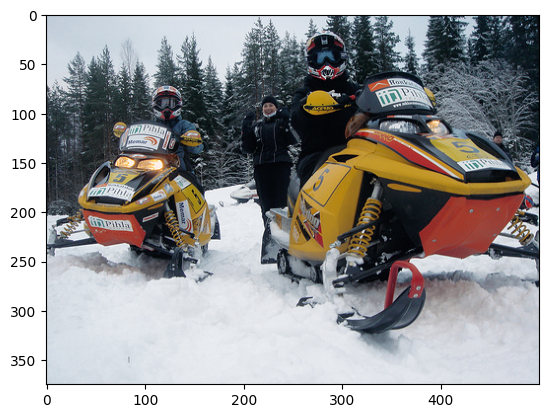

In [ ]:
generate_captions('109738916_236dc456ac.jpg')

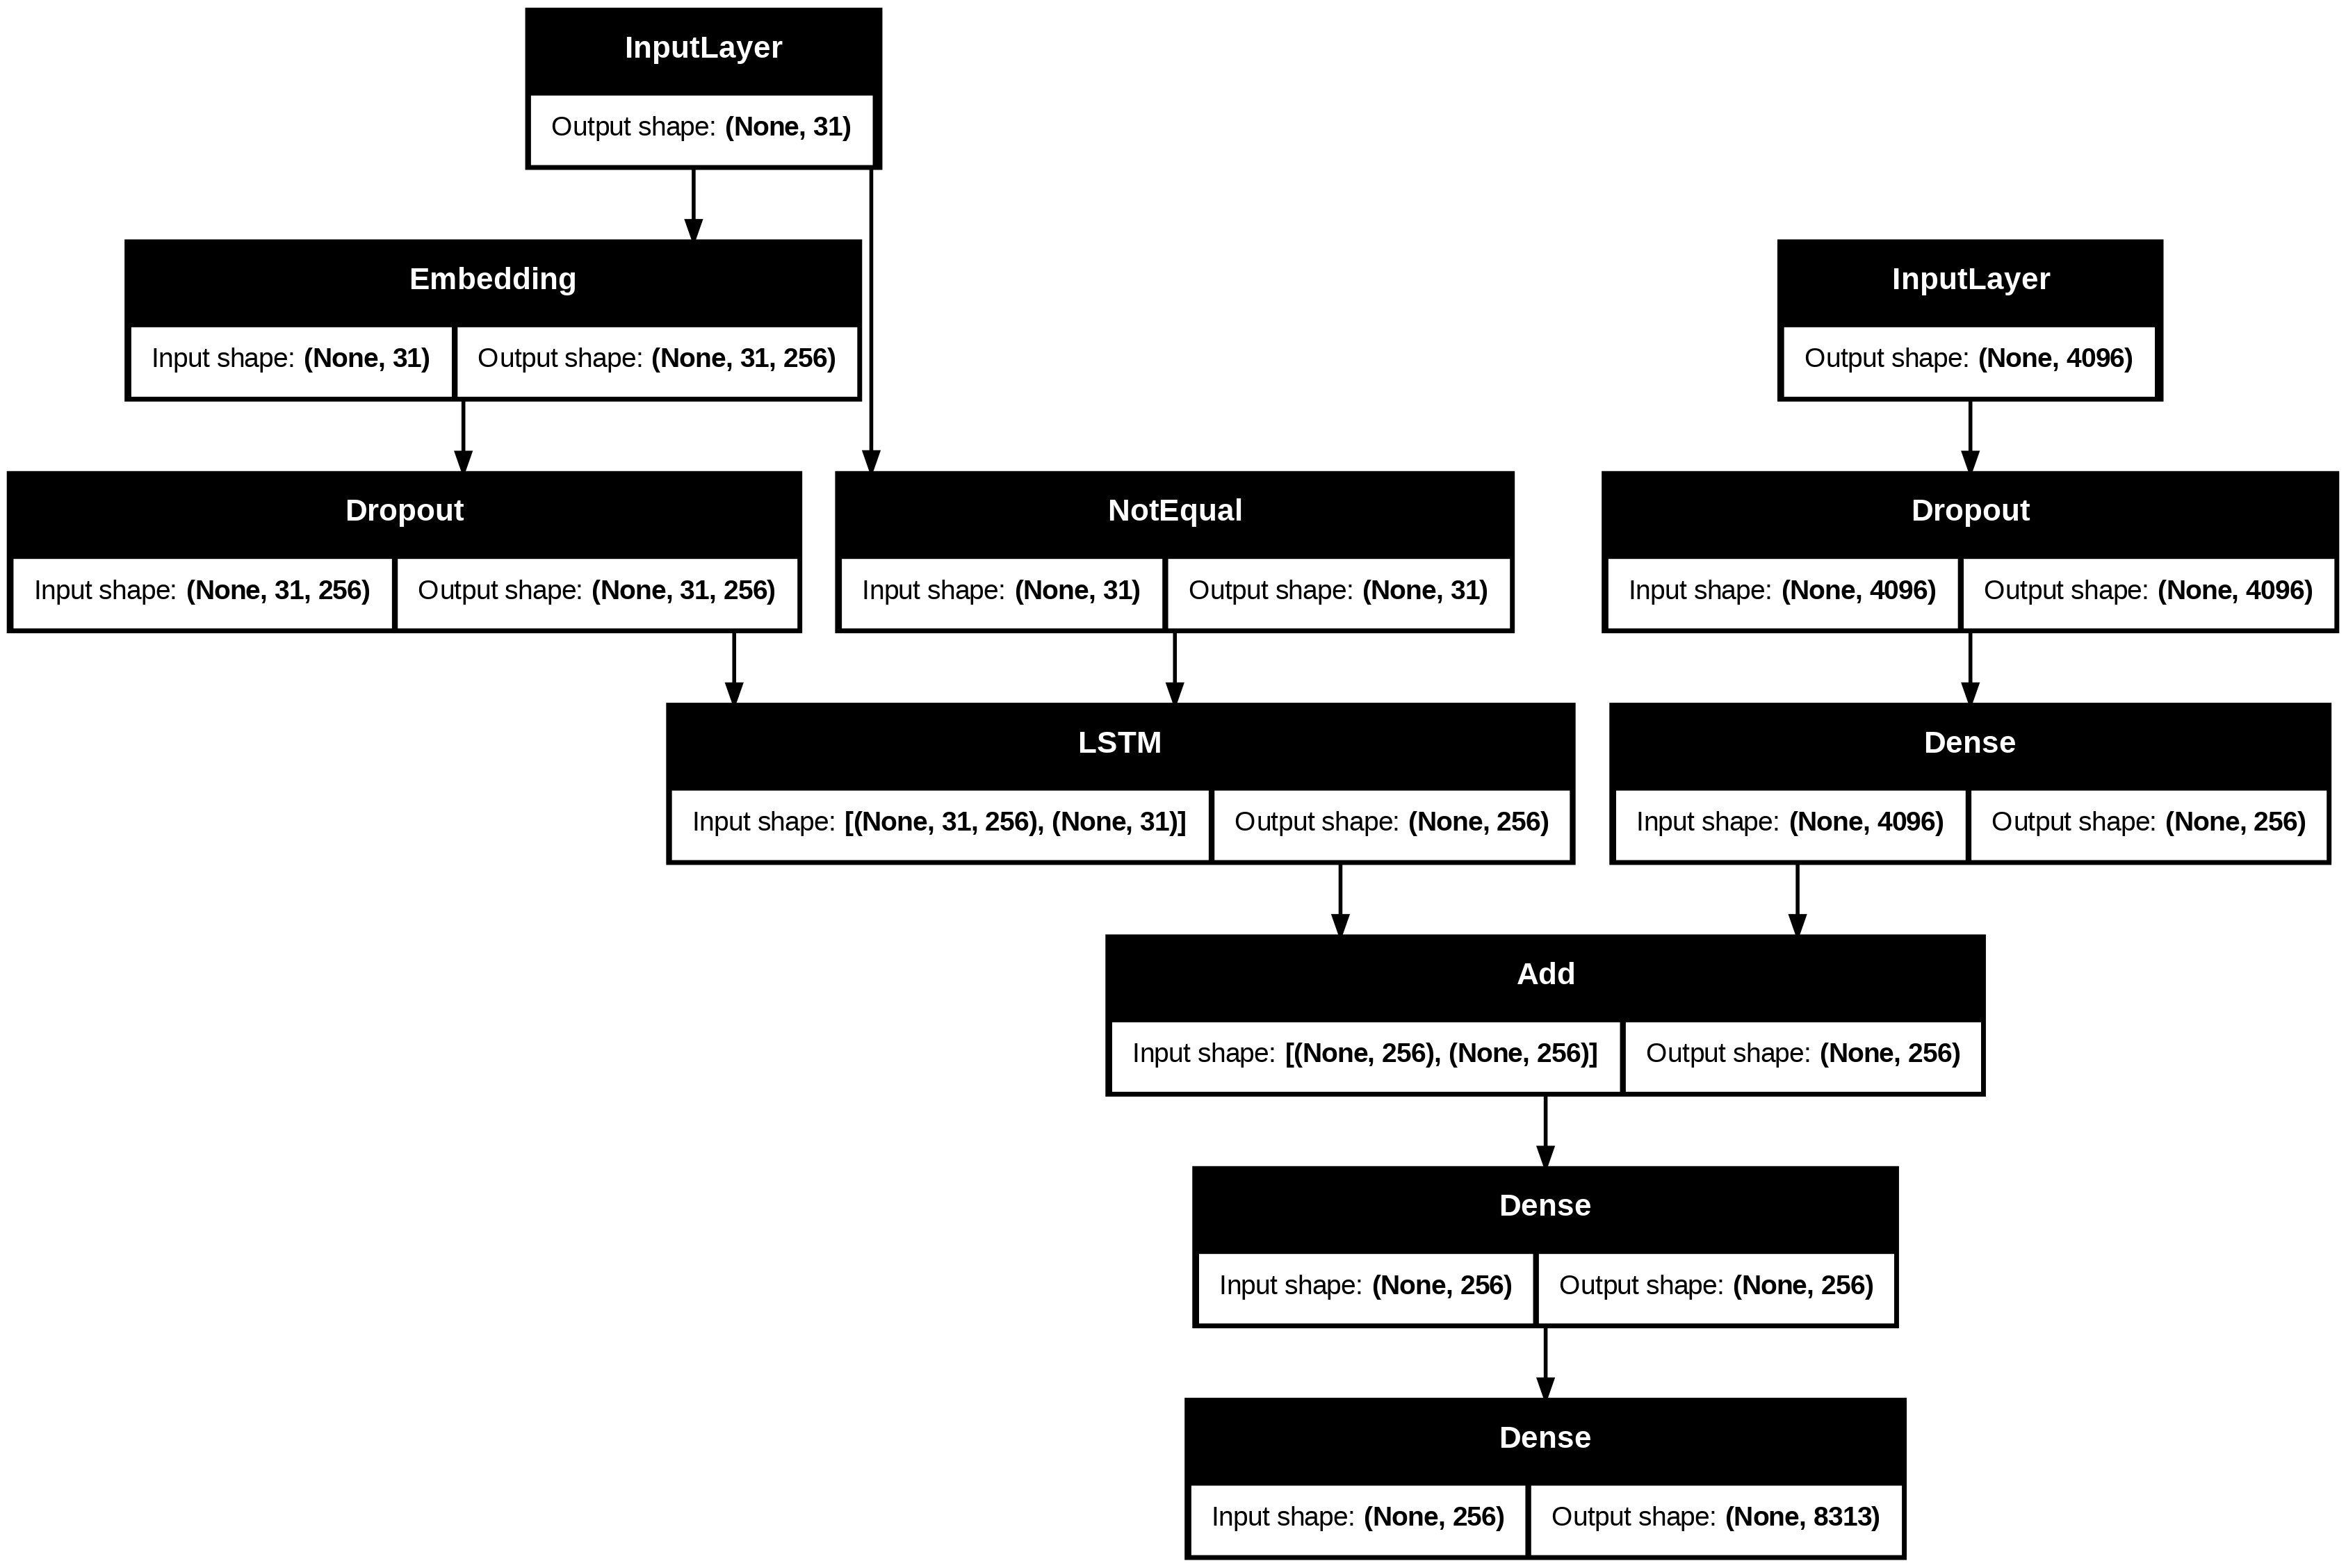

In [ ]:
# modelcreation

# encoder model
# img feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq fature layers
inputs2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)




# decoder model
decoder1 = add([fe2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# FILTER: Keep only image-caption mappings where features exist
mapping = {k: v for k, v in mapping.items() if k in features}

# FILTER: Update train list accordingly
train = [img_id for img_id in train if img_id in features]

# new
val = [img_id for img_id in test if img_id in features]

In [ ]:
# train the model with early stopping and validation

epochs = 15
batch_size = 64
steps = len(train) // batch_size
val_steps = len(val) // batch_size

# Generators
train_generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = datagenerator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1049s 9s/step - accuracy: 0.0956 - loss: 6.1197 - val_accuracy: 0.1823 - val_loss: 4.7498
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1039s 9s/step - accuracy: 0.2152 - loss: 4.4300 - val_accuracy: 0.2632 - val_loss: 3.9797
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1023s 9s/step - accuracy: 0.2748 - loss: 3.7347 - val_accuracy: 0.2799 - val_loss: 3.8405
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1041s 9s/step - accuracy: 0.2966 - loss: 3.4282 - val_accuracy: 0.2879 - val_loss: 3.8047
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1001s 9s/step - accuracy: 0.3137 - loss: 3.2188 - val_accuracy: 0.2945 - val_loss: 3.7782
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1004s 9s/step - accuracy: 0.3257 - loss: 3.0636 - val_accuracy: 0.2981 - val_loss: 3.7756
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1042s 9s/step - accuracy: 0.3388 - loss: 2.9329 - val_accuracy: 0.2968 - val_loss: 3.8451
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1000s 9s/step - accuracy: 0.3527 - loss: 2.8263 - 

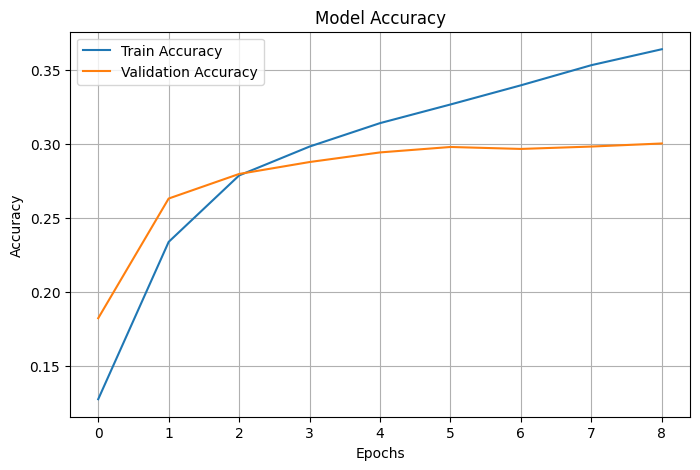

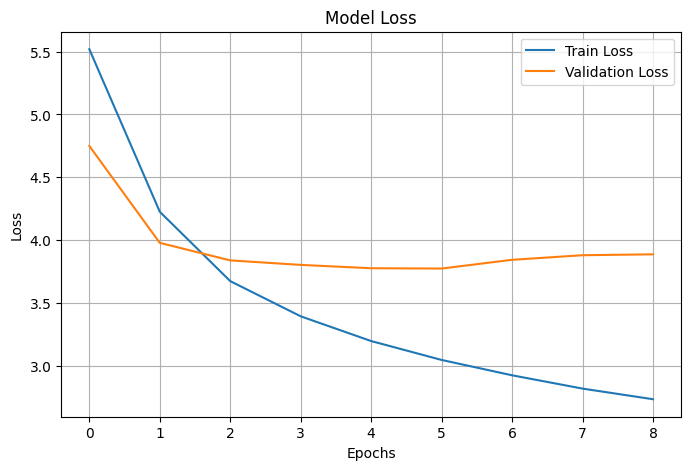

In [ ]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# save the model
model.save('model2.h5')

In [ ]:
# Generate Captions for the image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# validate with text data
actual, predict = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predict.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.578708
BLEU-2: 0.352008


In [ ]:
# visualize the results
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def generate_captions(image_name):
    # load the img
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog chases the water from sprinkler on lawn endseq
startseq brown dog plays with the hose endseq
startseq brown dog running on lawn near garden hose endseq
startseq dog is playing with hose endseq
startseq large brown dog running away from the sprinkler in the grass endseq
--------------------Predicted--------------------
startseq brown dog is jumping over lawn endseq


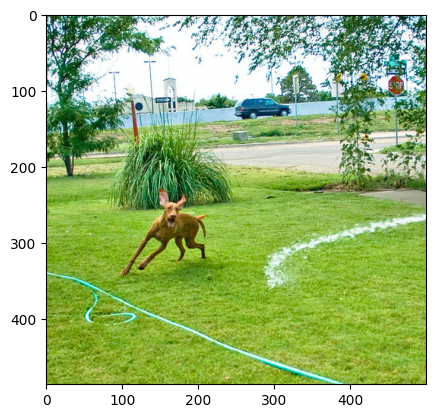

In [ ]:
generate_captions('1019077836_6fc9b15408.jpg')

---------------------Actual---------------------
startseq people are riding around on snowmobiles endseq
startseq people pose with helmets and goggles on while riding snowmobiles endseq
startseq several people are taking break while on snowmobiling ride endseq
startseq three people and two snowmobiles endseq
startseq two helmeted men sit on yellow snowmobiles while another man stands behind watching endseq
--------------------Predicted--------------------
startseq two people are on snowmobiling endseq


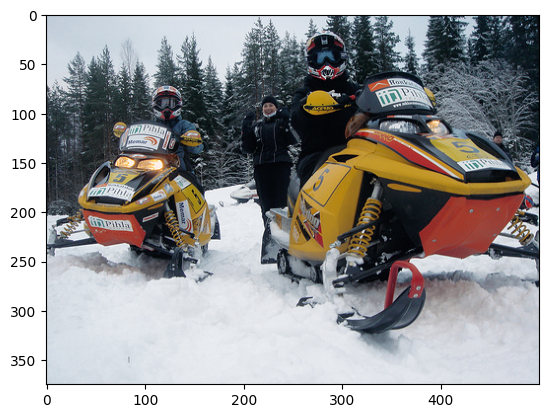

In [ ]:
generate_captions('109738916_236dc456ac.jpg')